In this notebook, I conducted experiments with the neural model of working memory by Compte et al. 

I'm using the ready model from the neurodynex3 package (https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex3.working_memory_network.html#module-neurodynex3.working_memory_network.wm_model).

Here, two experiments are present. Firstly, I partially reproduce the result of the bump attractor drift depending on the number of neurons in the population. And secondly, I explored how the shape of the bump changes among schizophrenia patients. It refers to the work Murray D. et al, 2014. More is below.  

In [4]:
%matplotlib inline
from neurodynex3.working_memory_network import wm_model
from neurodynex3.tools import plot_tools
import brian2 as b2

import numpy as np

import math

import matplotlib.pyplot as plt

import scipy as sc

In file included from /Users/rechique/Library/Caches/cython/brian_extensions/_cython_magic_1ba4a2cb3b90eedfa0a83d3836dfbdba.cpp:37:
In file included from /Users/rechique/opt/anaconda3/include/python3.9/Python.h:25:
/Users/rechique/opt/anaconda3/bin/../include/c++/v1/stdio.h:107:15: fatal error: 'stdio.h' file not found
#include_next <stdio.h>
              ^~~~~~~~~
1 error generated.
WARNING    Cannot use Cython, a test compilation failed: command '/Users/rechique/opt/anaconda3/bin/x86_64-apple-darwin13.4.0-clang' failed with exit code 1 (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slowe

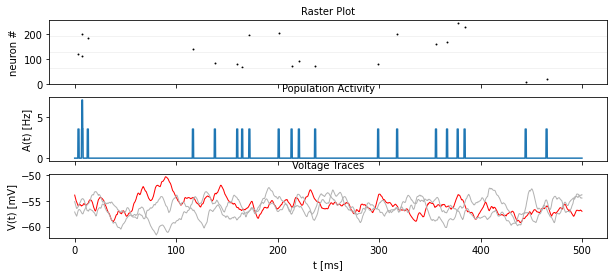

In [5]:
wm_model.getting_started()

## 1. Bump Drift

#### Here, the dump attractor drift is explored. The Bump shifts away from the initial applied signal due to noise. The souse of the noise is external stimulation of all neuron

In [22]:
# Return orientation based on neuron index

def get_orientation(idx_list, N):
    return [round((x+1/2)*360/N, 2) for x in idx_list]

# Return spikes which meet time requirements 
def get_spike_count(spike_monitor, spike_index_list, t_min, t_max):
    nr_neurons = len(spike_index_list)
    spike_count_list = np.zeros(nr_neurons)
    spike_trains = spike_monitor.spike_trains()
    
    filtered_spike_trains = [len([t for t in spikes if (t>=t_min) & (t<(t_max))]) \
                        for idx, spikes in spike_trains.items() if idx in spike_index_list]
    
    return filtered_spike_trains

# Return averaged preferred orientation. It's just averaged over separate neuron 
# vector where an amplitude is the firing rate and the angle is the preferred orientation
def get_theta_time_series(spike_monitor, N_exc, t_snapshots, window):
    pref_orients = []
    
    for t in t_snapshots:
        t_min = t-t_window/2
        t_max = t+t_window/2

        idx_list = list(range(0, N_exc))
        spike_counts = get_spike_count(spike_monitor, idx_list, t_min, t_max)
        spike_rates = spike_counts/(t_max-t_min)


        orientation = get_orientation(idx_list, N_exc)
        pref_orient = np.sum(spike_rates*orientation)/np.sum(spike_rates)
        
        pref_orients.append(pref_orient)
    return pref_orients

#### We start with the bigger population with 2048 excitatory neurons

In [273]:
N_exc = 2048

t_st_start = 100 * b2.ms
t_st_duration = 100 * b2.ms
t_sim = 2000 * b2.ms
t_window = 10*b2.ms

snapshot_interval = 5 * b2.ms

t_snapshots = range(
    int(math.floor((t_st_start+t_st_duration)/b2.ms)),  # lower bound
    int(math.floor((t_sim-t_window/2)/b2.ms)),  # Subtract half window. Avoids an out-of-bound error later.
    int(round(snapshot_interval/b2.ms))  # spacing between time stamps
    )*b2.ms

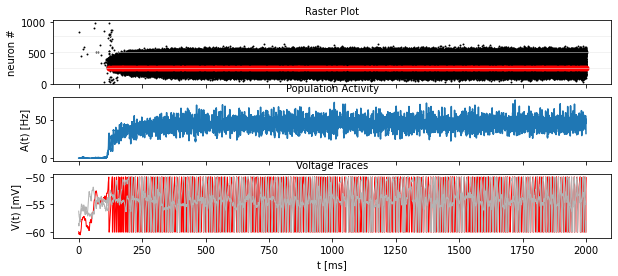

In [274]:
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(N_excitatory=N_exc, stimulus_center_deg=120, stimulus_width_deg=60, stimulus_strength=.2 * b2.namp, t_stimulus_start=t_st_start, t_stimulus_duration=t_st_duration, sim_time=t_sim)
fig, ax_raster, ax_rate, ax_voltage = plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * b2.ms)
plt.show()

In [275]:
theta_ts_2048 = get_theta_time_series(spike_monitor_excit, N_exc, t_snapshots, t_window)

#### And the population with 1024 excitatory neurons

In [276]:
N_exc = 1024

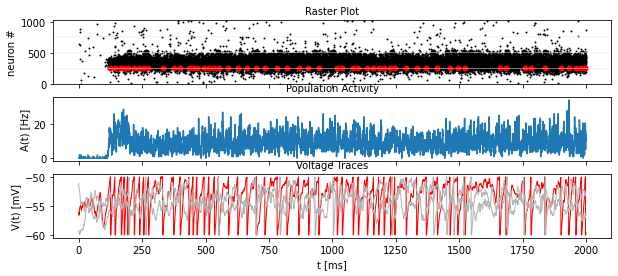

In [277]:
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(N_excitatory=N_exc, stimulus_center_deg=120, stimulus_width_deg=60, stimulus_strength=0.2 * b2.namp, t_stimulus_start=t_st_start, t_stimulus_duration=t_st_duration, sim_time=t_sim)
fig, ax_raster, ax_rate, ax_voltage = plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * b2.ms)
plt.show()

In [278]:
theta_ts_1024 = get_theta_time_series(spike_monitor_excit, N_exc, t_snapshots, t_window)

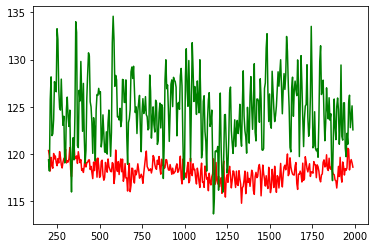

In [279]:
plt.plot(t_snapshots/b2.ms, theta_ts_2048, color='red', label='2048')
plt.plot(t_snapshots/b2.ms, theta_ts_1024, color='green', label='1024')

#### The drift effect is more pronounced for smaller populations. It can be the result of increased the signal to noise ratio. For the bigger population the more neurons are excited whereas the external input doesn't change. Therefore, the system is more stable

## 2. Schizophrenia increases width of the bump

#### In the work 'Linking Microcircuit Dysfunction to Cognitive Impairment: Effects of Disinhibition Associated with Schizophrenia in a Cortical Working Memory Model', schizophrenia is modeled though the injection of ketamine into patients. In computational terms, this is described as the decreased  strength of the connection between excitatory and inhibitory neurons, aka disinhibition

In [39]:
N_exc = 1024

t_st_start = 100 * b2.ms
t_st_duration = 50 * b2.ms
t_sim = 1000 * b2.ms

G_ei = 292. * b2.psiemens 

smooth_factor = 8

In [37]:
def get_firing_profile(spike_monitor, t_st_start, t_st_duration):
    # Return the firing rate of groups of neurons starting with the time of the beggining of the stimulus 
    # and their orientation
    
    filtered_spikes = {idx: [t for t in train if t > (t_st_start + t_st_duration)] for idx, train in spike_monitor.spike_trains().items()}
    firing_rates = [len(spikes) for idx, spikes in filtered_spikes.items()]
    firing_rates = np.array(firing_rates)
    firing_rates = firing_rates.reshape((-1, smooth_factor)).mean(-1)
    
    orientations = get_orientation([x*smooth_factor for x in range(len(firing_rates))], 1024) 
    return firing_rates, orientations

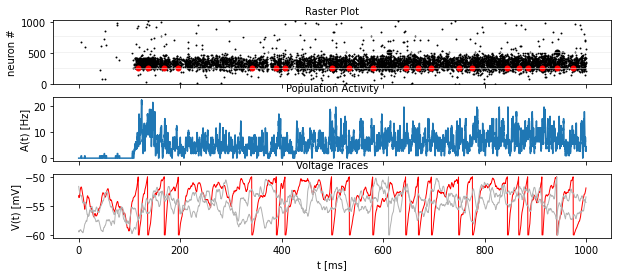

In [40]:
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(N_excitatory=N_exc, G_excit2inhib=G_ei, stimulus_center_deg=120, stimulus_width_deg=60, stimulus_strength=.2 * b2.namp, t_stimulus_start=t_st_start, t_stimulus_duration=t_st_duration, sim_time=t_sim)
fig, ax_raster, ax_rate, ax_voltage = plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * b2.ms)
plt.show()

In [44]:
stardard_firing_profile, orients = get_firing_profile(spike_monitor_excit, t_st_start, t_st_duration)

#### Here is the firing rate of neurons starting with the beginning the stimulus and it's normal distributed according to the Shapiro Wilk statistical test

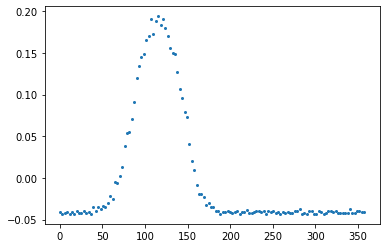

In [42]:
plt.plot(orients, stardard_firing_profile, 'o', ms=2)

In [45]:
norm_firing_rates = (stardard_firing_profile - np.mean(stardard_firing_profile))/np.var(stardard_firing_profile, ddof=1)
sc.stats.shapiro(firing_rates)

ShapiroResult(statistic=0.6211649188290946, pvalue=1.1303671425693558e-16)

In [52]:
np.var(stardard_firing_profile, ddof=1)

89.1751968503937

#### In Murray's work, schizophrenia (aka the ketamine model) is modeled by decreasing the connection from excitatory to inhibitory populations by 3%. Let's do as they did

In [47]:
G_ei = 292. * b2.psiemens * 0.97

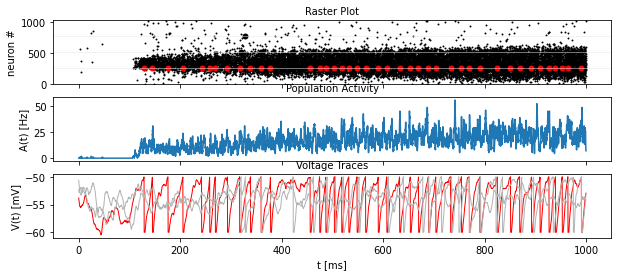

In [48]:
rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, idx_monitored_neurons_excit, rate_monitor_inhib, spike_monitor_inhib, voltage_monitor_inhib, idx_monitored_neurons_inhib, w_profile = wm_model.simulate_wm(N_excitatory=N_exc, G_excit2inhib=G_ei, stimulus_center_deg=120, stimulus_width_deg=60, stimulus_strength=.2 * b2.namp, t_stimulus_start=t_st_start, t_stimulus_duration=t_st_duration, sim_time=t_sim)
fig, ax_raster, ax_rate, ax_voltage = plot_tools.plot_network_activity(rate_monitor_excit, spike_monitor_excit, voltage_monitor_excit, t_min=0. * b2.ms)
plt.show()

In [49]:
sci_firing_profile, orients = get_firing_profile(spike_monitor_excit, t_st_start, t_st_duration)

#### As we see the bump becomes broader and the variance are increased

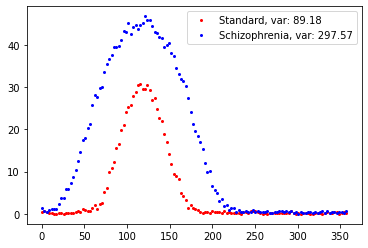

In [58]:
plt.plot(orients, stardard_firing_profile, 'o', ms=2, color='red', label=f'Standard, var: {round(np.var(stardard_firing_profile, ddof=1), 2)}')
plt.plot(orients, sci_firing_profile, 'o', ms=2, color='blue', label=f'Schizophrenia, var: {round(np.var(sci_firing_profile, ddof=1), 2)}')
plt.legend()